In [1]:
print("Hello world")

Hello world


In [2]:
i = 9

In [3]:
i = i + 2

In [4]:
print(i)

11


In [21]:
!nvidia-smi

Thu Jan 16 11:14:12 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0              26W /  70W |    105MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
%%time
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp311-cp311-linux_x86_64.whl size=660362 sha256=c9955f1aa3213d62705dee29991c3aaa059e8c971d5ae58ad3cbcf1d15a27aff
  Stored in directory: /root/.cache/pip/wheels/76/66/50/c65e6116d7e0e16abe0f7c19b50327f76724ccfefbdc61a1b9
Successfully built pycuda


In [8]:
#Import pycuda and specific submodules

import pycuda
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

In [9]:
#Remember to initialize CUDA!!!
import pycuda.autoinit

In [10]:
#import Numpy to generate numbers on the CPU
import numpy as np

In [11]:
#First, generate some random numbers on the CPU
a = np.random.randn(4,4).astype(dtype=np.float32)
print(a)

[[ 1.9247125  -0.13375367  0.2532029   0.14165576]
 [ 0.51895756  0.73391616 -0.9988885  -1.4622518 ]
 [ 0.02906531  0.00582248  0.0410804  -0.45742336]
 [ 0.32707864 -0.49536744 -0.1682191  -0.49999222]]


In [12]:
#Print some information about a:
print(a.dtype)
print(a.nbytes)

float32
64


In [13]:
#Double check if size makes sense:
a_num_elements = 4*4
num_bytes_per_element = 4 #NB: single precision is 4 bytes, double 8
print(a_num_elements*num_bytes_per_element)

64


In [14]:
#Transfer the data to the GPU (and allocate data there)
a_gpu = cuda.mem_alloc(a.nbytes)

In [15]:
#Copy data from host (cpu, numpy, a) to device (gpu, pycuda, a_gpu)
cuda.memcpy_htod(a_gpu, a)

In [16]:
kernel_src = """
//Important: This expects a_gpu to be single precision numbers,
//           not double precision
__global__ void double_a(float* a_gpu) {
    int tid = threadIdx.x + threadIdx.y * 4;

    a_gpu[tid] = a_gpu[tid]*2+1;
}
"""

mod = SourceModule(kernel_src) #Create the source module from the source code
func = mod.get_function("double_a") #Get the compiled function double_a from the source code

In [17]:
func(a_gpu, block=(4,4,1),grid=(1,1,1))

In [18]:
#print out what a_gpu is:
b = np.empty_like(a) #create an empty array equal in datatype and size to al
cuda.memcpy_dtoh(b, a_gpu)

print(a)
print(b)

print(2*a-b)

[[ 1.9247125  -0.13375367  0.2532029   0.14165576]
 [ 0.51895756  0.73391616 -0.9988885  -1.4622518 ]
 [ 0.02906531  0.00582248  0.0410804  -0.45742336]
 [ 0.32707864 -0.49536744 -0.1682191  -0.49999222]]
[[ 4.8494253e+00  7.3249269e-01  1.5064058e+00  1.2833115e+00]
 [ 2.0379152e+00  2.4678323e+00 -9.9777699e-01 -1.9245036e+00]
 [ 1.0581306e+00  1.0116450e+00  1.0821608e+00  8.5153282e-02]
 [ 1.6541573e+00  9.2651248e-03  6.6356182e-01  1.5556812e-05]]
[[-1.0000002 -1.        -1.        -1.       ]
 [-1.0000001 -1.        -1.        -1.       ]
 [-1.        -1.        -1.        -1.       ]
 [-1.        -1.        -1.        -1.       ]]


In [19]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Publish this graph')

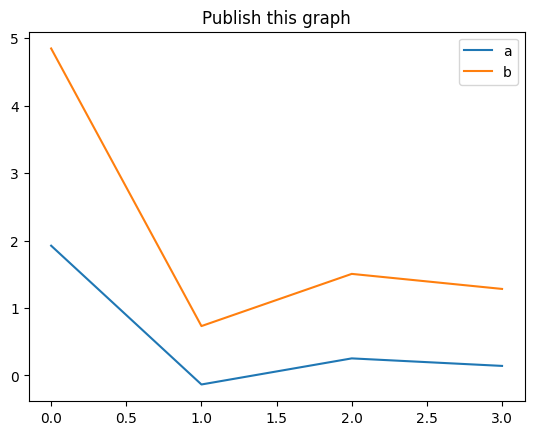

In [20]:
plt.plot(a[0,:], label='a')
plt.plot(b[0,:], label='b')
plt.legend()
plt.title('Publish this graph')